In [1]:
import Pkg; Pkg.activate(".")

  Activating project at `~/SAFT_ML`


In [18]:
using Revise

# Equations of state
using Clapeyron
includet("./saftvrmienn.jl")
import Clapeyron: a_res

# Generating molecular feature vectors
using RDKitMinimalLib 

# Machine learning
using Flux
using ForwardDiff, DiffResults
using Zygote, ChainRulesCore

# Misc
using Statistics, Random, Plots

In [3]:
m = SAFTVRMie(["propane"])
m.params.segment

SingleParam{Float64}("segment") with 1 component:
 "propane" => 1.6845

In [4]:
function differentiable_saft(X::AbstractVector{T}) where T <: Real
    model = SAFTVRMieNN(
        params = SAFTVRMieNNParams(
            Mw=T[16.04],
            segment=T[X[1]],
            sigma=T[X[2]],
            lambda_a=T[X[3]],
            lambda_r=T[X[4]],
            epsilon=T[X[5]],
            epsilon_assoc=T[],
            bondvol=T[],
        )
    )
    return a_res(model, T(1e-4), T(300.0), T[1.0])
end
X_nom_meth = Float32[1.0, 3.737e-10, 6.0, 12.504, 152.58]

typeof(differentiable_saft(X_nom_meth))

Float32

In [5]:
function ChainRulesCore.rrule(::typeof(differentiable_saft), x)
    y = differentiable_saft(x)
    
    function f_pullback(Δy)
        # Use ForwardDiff to compute the gradient
        ∂x = ForwardDiff.gradient(differentiable_saft, x) .* Δy # Note: element-wise multiplication
        return (NoTangent(), ∂x)
    end
    
    return y, f_pullback
end

# Test the gradient computation
Zygote.gradient(differentiable_saft, X_nom_meth)

(Float32[0.1339519, -1.2769684f9, 0.23822455, 0.053698346, -0.0064937966],)

In [6]:
# Define neural network
#? What inputs should we take
#! Should use inputs from previous ML coursework (ΔG_mix prediction)
model = Chain(
    Dense(2, 10, relu),
    Dense(10, 5, relu),
)

# X are SAFTVRMie parameter predictions
ref_model = GERG2008(["methane"])
ref_a::Float32 = a_res(ref_model, 1e-4, 300.0, [1.0])
function test_loss(X)
    a = differentiable_saft(X)
    return (a - ref_a)^2
end

model(Float32[1.3, 1.0])

5-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.34398475
 1.073288

test_loss(X_nom_meth) = 0.00010405325f0


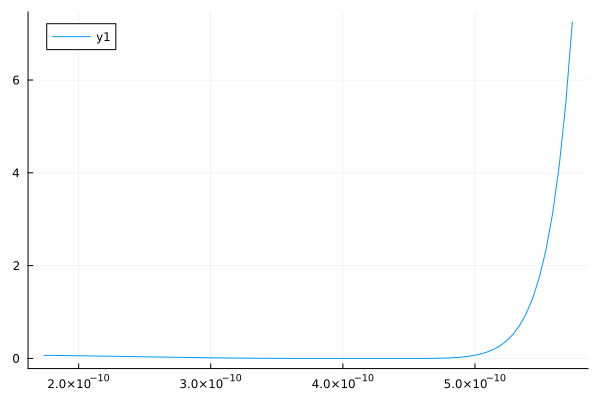

In [7]:
# Zygote.gradient(test_loss, [3.737e-10, 6.0, 12.504, 152.58])
@show test_loss(X_nom_meth)

x_nom = 3.737e-10
δx = [2e-10, 2e-10]
plot(x -> test_loss([1.0, x, 6.0, 12.504, 152.58]), x_nom-δx[1]:5e-12:x_nom+δx[2])

__Below is a test neural network on random data, to see if the network weights will update__

In [8]:
# Define the unbounded neural network model
model_unbounded = Chain(
    Dense(2, 10, relu),
    Dense(10, 5)
)

# Nominal values
# x_nominal = [3.737e-10, 6.0, 12.504, 152.58]

# Custom barrier function to bound the output within ±n⨯ of the nominal value
function bounded_output(x_nn_output, x_nom, n=0.1)
    return x_nom .+ 0.1 .* x_nom .* tanh.(x_nn_output)
end

# Model with bounded output
bounded_model(x) = bounded_output(model_unbounded(x), X_nom_meth)

bounded_model (generic function with 1 method)

In [9]:
# Initial data: Replace these with your actual input (X) and target (y) data
# Assuming each row in X_data is a 2-element vector that serves as input to the neural network
X_data = rand(Float32, 100, 2)  # 100 samples, each with 2 features
y_data = rand(Float32, 100)  # 100 samples, each with one target value

# Hyperparameters
learning_rate = 0.01
epochs = 10

# Optimizer
opt = ADAM(learning_rate)

# @show Flux.params(model_unbounded)
# Training Loop
for epoch in 1:epochs
    loss_vec = []
    for (i, X) in enumerate(eachrow(X_data))
        # X = X_data[i, :]
        y_nom = y_data[i]

        # Compute the loss
        #! Make sure loss is only computed once
        loss_fn() = begin
            # Forward pass through the neural network to get SAFT parameter predictions
            X_pred = bounded_model(X)
            a = differentiable_saft(X_pred)
            (a - y_nom)^2
        end
        # loss_fn(X_pred)

        append!(loss_vec, loss_fn())
        
        # Compute gradients
        grads = Zygote.gradient(Flux.params(model_unbounded)) do
            loss_fn()
        end
        # @show grads.params
        # grads = Zygote.gradient(loss_fn)

        # Update model parameters
        Flux.update!(opt, Flux.params(model_unbounded), grads)
    end
    # You can add validation and logging here
    println("Epoch: $epoch, Loss: $(mean(loss_vec))")
end

Epoch: 1, Loss: 0.41663057540687487
Epoch: 2, Loss: 0.3175325482620729
Epoch: 3, Loss: 0.3092215390781678
Epoch: 4, Loss: 0.3091011041246321
Epoch: 5, Loss: 0.3090497843511747
Epoch: 6, Loss: 0.30902249448654456
Epoch: 7, Loss: 0.3090060538750253
Epoch: 8, Loss: 0.30899530110486667
Epoch: 9, Loss: 0.30898784410837954
Epoch: 10, Loss: 0.3089824323577807


In [10]:
Flux.params(model_unbounded)

Params([Float32[-0.6226996 -0.16620626; 0.98194104 -0.28659657; … ; 0.7981105 0.83903706; -0.10523503 -0.4631473], Float32[0.0, 0.45728457, -0.19788471, 0.0, 0.0, 0.5100455, 0.7568676, 0.58031785, 1.0370052, 0.0], Float32[0.2723273 -0.32025743 … -1.1387428 0.21469887; 0.29758707 0.3778945 … 1.6550894 -0.49664465; … ; -0.40684593 0.78381246 … 1.9008845 0.473569; 0.56764483 -0.7427464 … -1.5841653 -0.080814235], Float32[-0.38790488, 0.01671916, 0.4509274, 0.34953395, -0.39776137]])

It trains! Now it's time to set up a real dataset. We're going to be generating data from GERG2008, which provides highly accurate data for the following species:

Hydrocarbons:
- methane
- ethane
- propane
- butane
- isobutane
- pentane
- isopentane
- hexane
- heptane
- octane
- nonane
- decane

Elemental molecules:
- helium
- argon
- oxygen
- nitrogen
- hydrogen

Gases
- carbondioxide
- carbonmonoxide
- hydrogensulfide

Water, the only associating compound
- water #! We won't include water


The _y_ data will be the residual helmholtz free energy, a_res, sampled in a range of V, T space. Initially, I'm sampling between 0.5 and 1.5 of the critical point.

__TO CHECK LATER:__
- The GERG2008 equations of state will have published validity ranges. These must be respected.
- Potentially the ideal model used within GERG should be considered if trying to fit to heat capacity data, or similar. Check what properties the heat capacity influences.

In [11]:
# Initially sample data for hydrocarbons
#! isobutane, isopentane not defined for SAFTVRMie
species = [
    "methane",
    "ethane",
    "propane",
    "butane",
    # "isobutane",
    "pentane",
    # "isopentane",
    "hexane",
    "heptane",
    "octane",
    "nonane",
    "decane",
]

# Define smiles map
smiles_map = Dict(
    "methane" => "C",
    "ethane" => "CC",
    "propane" => "CCC",
    "butane" => "CCCC",
    "isobutane" => "CC(C)C",
    "pentane" => "CCCCC",
    "isopentane" => "CC(C)CC",
    "hexane" => "CCCCCC",
    "heptane" => "CCCCCCC",
    "octane" => "CCCCCCCC",
    "nonane" => "CCCCCCCCC",
    "decane" => "CCCCCCCCCC",
)

function make_fingerprint(s::String)::Vector{Float32}
    mol = get_mol(s)
    @assert !isnothing(mol)
    fp_details = Dict{String,Any}("nBits" => 16, "radius" => 3)

    fp_str = get_morgan_fp(mol, fp_details)
    morgan_fp = [parse(Float32, string(c)) for c in fp_str]

    # Can later add additional details, e.g. molar weight, measures of branching, etc.
    # Can also add different radii fps
    return morgan_fp
end

# X data contains fingerprint, V, T
# Y data contains a_res
T = Float32
X_data = Vector{Tuple{Vector{T},T,T, String}}([])
Y_data = Vector{Vector{T}}()

for s in species
    model = GERG2008([s])
    Tc, pc, Vc = crit_pure(model)
    smiles = smiles_map[s]

    fingerprint = make_fingerprint(smiles)

    T_range = range(0.5 * Tc, 1.5 * Tc, 1000)
    V_range = range(0.5 * Vc, 1.5 * Vc, 1000) # V could be sampled from a logspace
    for T in T_range
        for V in V_range
            push!(X_data, (fingerprint, V, T, s))

            a = a_res(model, V, T, [1.0])
            push!(Y_data, Float32[a])
        end
    end
end

# Should randomly shuffle data
#? Split into train, validation set too?

@show size(X_data), X_data[1]
@show size(Y_data), Y_data[1]
nothing

(size(X_data), X_data[1]) = ((10000000,), (Float32[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4.931286f-5, 95.282f0, "methane"))
(size(Y_data), Y_data[1]) = ((10000000,), Float32[-5.767815])


In [12]:
# Generate nominal X dictionary
nominal_X = Dict{String,Vector{Float32}}()
for s in species
    model = SAFTVRMie([s])

    nominal_X[s] = [
        model.params.segment[1],
        model.params.sigma[1],
        model.params.lambda_a[1],
        model.params.lambda_r[1],
        model.params.epsilon[1],
    ]
end
nominal_X #! Looks like lambda_a should be fixed at 6.0

Dict{String, Vector{Float32}} with 10 entries:
  "hexane"  => [2.1097, 4.423f-10, 6.0, 17.203, 354.38]
  "butane"  => [1.8514, 4.0887f-10, 6.0, 13.65, 273.64]
  "decane"  => [2.9976, 4.589f-10, 6.0, 18.885, 400.79]
  "nonane"  => [2.8099, 4.5334f-10, 6.0, 18.324, 387.55]
  "pentane" => [1.9606, 4.2928f-10, 6.0, 15.847, 321.94]
  "propane" => [1.6845, 3.9056f-10, 6.0, 13.006, 239.89]
  "heptane" => [2.3949, 4.4282f-10, 6.0, 17.092, 358.51]
  "methane" => [1.0, 3.737f-10, 6.0, 12.504, 152.58]
  "ethane"  => [1.4373, 3.7257f-10, 6.0, 12.4, 206.12]
  "octane"  => [2.6253, 4.4696f-10, 6.0, 17.378, 369.18]

In [13]:
X_data

10000000-element Vector{Tuple{Vector{Float32}, Float32, Float32, String}}:
 ([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4.931286f-5, 95.282, "methane")
 ([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4.9411585f-5, 95.282, "methane")
 ([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4.951031f-5, 95.282, "methane")
 ([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4.9609036f-5, 95.282, "methane")
 ([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4.970776f-5, 95.282, "methane")
 ([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4.9806484f-5, 95.282, "methane")
 ([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 4.9905208f-5, 95.282, "methane")
 ([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 5.000393f-5, 95.282, "met

In [16]:
# Define the unbounded neural network model
input_dim = length(X_data[1][1])
hidden_dim = 256
output_dim = 5

# Using relu activation function for now
unbounded_model = Chain(
    Dense(input_dim, hidden_dim, relu),
    Dense(hidden_dim, hidden_dim, relu),
    Dense(hidden_dim, hidden_dim, relu),
    Dense(hidden_dim, hidden_dim, relu),
    Dense(hidden_dim, output_dim)
)

# @show 

# Nominal values
#! Want to directly predict the parameters, not a relative change
#* Need a different way to bound NN output
#* Especially for learning across different compounds
# x_nominal = [3.737e-10, 6.0, 12.504, 152.58]

# Custom barrier function to bound the output within ±n⨯ of the nominal value while keeping derivatives
function bounded_output(x_nn_output, x_nom)
    return @. x_nom - 0.5 * x_nom * tanh(x_nn_output - x_nom)
end

# Model with bounded output
bounded_model(x, x_nom) = bounded_output(unbounded_model(x), x_nom)

# Hyperparameters
learning_rate = 0.01
epochs = 200

# Optimizer
opt = ADAM(learning_rate)

loss_vec = Float32[]
# Training Loop
for epoch in 1:epochs
    epoch_loss_vec = Float32[]
    for (X, y) in zip(X_data, y_data)
        # Split X into fingerprint, V, T
        fp, V, T, s = X
        X_nom = nominal_X[s]

        y = y[1]

        # Compute the loss
        #! Make sure loss is only computed once
        loss = nothing
        loss_fn() = begin
            # Forward pass through the neural network to get SAFT parameter predictions
            #! nominal X is used to bound the output
            X_pred = bounded_model(fp, X_nom)
            ŷ = differentiable_saft(X_pred)
            loss = (ŷ - y)^2
        end

        # Compute gradients
        grads = Zygote.gradient(Flux.params(unbounded_model)) do
            loss_fn()
        end

        append!(epoch_loss_vec, loss)

        # Update model parameters
        Flux.update!(opt, Flux.params(unbounded_model), grads)
    end
    mean_loss = mean(epoch_loss_vec)
    append!(loss_vec, mean_loss)
    # You can add validation and logging here
    if epoch in [1, 5, 10] || epoch % 20 == 0
        println("Epoch: $epoch, Loss: $mean_loss")
    end
end

Epoch: 1, Loss: 0.1389488


Epoch: 5, Loss: 0.1867193


Epoch: 10, Loss: 0.18688135


Epoch: 20, Loss: 0.18688135


Epoch: 40, Loss: 0.18688135


Epoch: 60, Loss: 0.18688135


Epoch: 80, Loss: 0.18688135


Epoch: 100, Loss: 0.18688135


Epoch: 120, Loss: 0.18688135


Epoch: 140, Loss: 0.18688135


Epoch: 160, Loss: 0.18688135


Epoch: 180, Loss: 0.18688135


Epoch: 200, Loss: 0.18688135


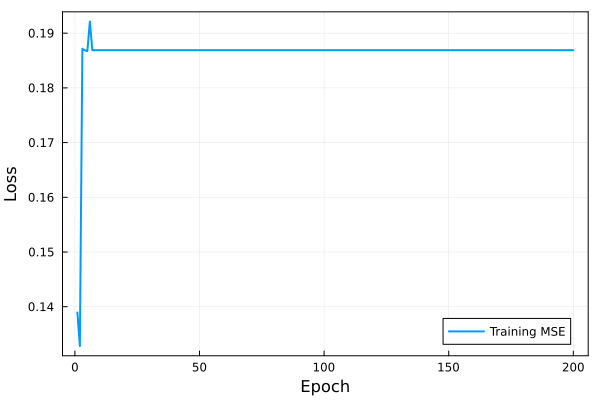

In [17]:
plot(1:epochs, loss_vec, xlabel="Epoch", ylabel="Loss", label="Training MSE", lw=2, box=:on)